In [ ]:
def dataset_labeled(multiQC_data, others_data):
    """
    generates labeled dataset
    """
    #aico = aico_min
    #print('Lattice constant [Å]', aico)

    myData = []
    # multiQC_data, others_data = dataset(wvl, QC_peaks, aico_min, aico_delta, hklmno_range, tth_min, tth_max, tth_step, data_num_qc, data_num_non_qc)

    # Multi-iQC
    #virtualQC_data = pxrd.calc_virtualiQC(data_num_qc, QC_peaks, wvl, aico, aico+aico_delta, tth_min, tth_max, tth_step)
    #multiQC_data = pxrd.calc_multiQC(virtualQC_data, tth_min, tth_max, tth_step)
    for i in multiQC_data:
        myData.append([i,1])

    # Non-iQC
    #others_data = pxrd.calc_others(data_num_non_qc, tth_min, tth_max, tth_step)
    for i in others_data:
        myData.append([i,0])

    random.shuffle(myData)
    x_data = []
    y_data = []
    for feature, label in myData:
        x_data.append(feature)
        y_data.append(label)

    #np.save('./x_data.npy', x_train)
    #np.save('./y_data.npy', y_train)
    x_data = np.array(x_data, dtype='float64')
    y_data = np.array(y_data, dtype='float64')

    return x_data, y_data


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 32.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
import numpy as np
import random
import keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D ,Dropout, MaxPooling1D ,InputLayer
# from keras.layers.pooling import GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from keras import regularizers
import glob
import math
import optuna
from tensorflow.keras import Sequential
import gc

dic_wvl = {}
dic_wvl['Cu_Ka'] = 1.54059


path_model = './models'
if os.path.isdir('%s'%(path_model))==False:
    os.mkdir('%s'%(path_model))


##トレーニング用データ
multiQC_data = np.load('/content/drive/MyDrive/virtual_QC/training_dodeca.npy')
others_data = np.load('/content/drive/MyDrive/virtual_QC/training_others.npy')
x_train, y_train = dataset_labeled(multiQC_data, others_data)

##テスト用データ
multiQC_test = np.load('/content/drive/MyDrive/virtual_QC/test_dodeca.npy')
others_test = np.load('/content/drive/MyDrive/virtual_QC/test_others.npy')
x_test, y_test = dataset_labeled(multiQC_test, others_test)

input_=x_train.shape[1]
# tf.keras.backend.set_floatx('float64')
x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]


# Optunaの目的関数
def objective(trial):
    # ハイパーパラメータの探索範囲を定義
    # num_conv_layers = trial.suggest_int("num_conv_layers", 1, 4, step=1)  # 畳み込み層の数
    num_conv_layers = 3
    # conv_filters = trial.suggest_int("conv_filters", 32, 128, step=32)  # 畳み込み層のフィルター数
    conv_filters = 64
    # kernel_size = trial.suggest_int("kernel_size", 10, 50, step=10)  # 畳み込み層のフィルターサイズ
    kernel_size = 30
    # strides = trial.suggest_int("strides", 1, 3, step=1)  # 畳み込み層のストライド
    strides = 3
    # pool_size = trial.suggest_int("pool_size", 1, 3, step=1)  # プーリング層のプールサイズ
    pool_size = 1
    # pool_strides = trial.suggest_int("pool_strides", 1, 3, step=1)  # プーリング層のストライド
    pool_strides = 2
    # num_dense_layers = trial.suggest_int("num_dense_layers", 1, 3, step=1)  # 全結合層の数
    num_dense_layers = 2
    # dense_units = trial.suggest_int("dense_units", 500, 3000, step=500)  #全結合層のニューロン数
    dense_units = 1000

    # dense_units = trial.suggest_int("dense_units", 64, 256, step=32)  # 最初の全結合層のユニット数

    # dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5, step=0.1)  #Dropout
    dropout_rate = 0.5
    # optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd", "rmsprop", "adagrad"])  #最適化アルゴリズム

    optimizer_name = trial.suggest_categorical("optimizer", ["adam", "sgd"])  #最適化アルゴリズム
    # optimizer_name = "adam"

    # learning_rate = trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True)  #学習率
    learning_rate = 0.001
    # reduction_factor = trial.suggest_float("reduction_factor", 0.5, 1.0, step=0.1)  # 層ごとのユニット数の減少率
    reduction_factor = 0.5
    # batch_num = trial.suggest_int("batch_size", 32, 256, step=32)  #パッチサイズ
    batch_num=256
    # epoch_num = trial.suggest_int("epochs", 5, 25, step=5)  #エポック数
    epoch_num=15

    # 選択されたoptimizerを設定
    if optimizer_name == "adam":
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer_name == "sgd":
        optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)
    # elif optimizer_name == "rmsprop":
    #     optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
    # elif optimizer_name == "adagrad":
    #     optimizer = tf.keras.optimizers.Adagrad(learning_rate=learning_rate)

    # モデルの構築
    model = Sequential()
    for i in range(num_conv_layers):  # 畳み込み層を動的に追加
        if i == 0:
            # 最初の畳み込み層（input_shapeを指定）
            model.add(Conv1D(conv_filters, kernel_size=kernel_size, strides=strides, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
        else:
            # 2層目以降の畳み込み層
            model.add(Conv1D(conv_filters, kernel_size=kernel_size, strides=strides, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)))
        model.add(MaxPooling1D(pool_size,  strides=pool_strides, padding='valid'))

    # # Flattenで入力を整形
    model.add(Flatten())

    # 全結合層を追加
    for i in range(num_dense_layers):
        model.add(Dense(dense_units, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
        model.add(Dropout(dropout_rate))
        dense_units = int(dense_units * reduction_factor)  # ユニット数を減少

    # 出力層
    model.add(Dense(2, activation='sigmoid'))

    # Optimizerの設定
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    #最適化アルゴリズム, 損失関数(Sparse Categorical CrossEntropy)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # モデルのトレーニング
    training_model = model.fit(x_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_split=0.2)

    model.evaluate(x_test, y_test, verbose=2)

    # 検証データの精度を最適化対象とする
    val_accuracy = max(training_model.history['val_accuracy'])

    # GPUメモリを解放
    tf.keras.backend.clear_session()
    gc.collect()

    return val_accuracy

# Optunaのスタディを作成して最適化を実行
study = optuna.create_study(direction="maximize")  # 検証精度を最大化
study.optimize(objective, n_trials=6)  # 試行回数を指定

# 最適な結果を表示
print("Best Trial:")
print(f"  Accuracy: {study.best_value}")
print(f"  Params: {study.best_params}")

[I 2025-01-29 08:06:36,089] A new study created in memory with name: no-name-ed3259a0-cb64-443f-b024-fead53d91e02


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.8785 - loss: 5.8413 - val_accuracy: 0.9639 - val_loss: 0.2172
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9582 - loss: 0.2206 - val_accuracy: 0.9564 - val_loss: 0.2057
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9616 - loss: 0.1989 - val_accuracy: 0.9712 - val_loss: 0.1799
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9676 - loss: 0.1800 - val_accuracy: 0.9726 - val_loss: 0.1714
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9674 - loss: 0.1736 - val_accuracy: 0.9693 - val_loss: 0.1631
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9681 - loss: 0.1726 - val_accuracy: 0.9727 - val_loss: 0.1552
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9690 - loss: 0.1678 - val_accuracy: 0.9729 - val_loss: 0.1631
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9699 - loss: 0.1635 - val_accuracy: 

[I 2025-01-29 08:07:15,194] Trial 0 finished with value: 0.9771666526794434 and parameters: {'optimizer': 'sgd'}. Best is trial 0 with value: 0.9771666526794434.


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8501 - loss: 5.7062 - val_accuracy: 0.9647 - val_loss: 0.2155
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9591 - loss: 0.2089 - val_accuracy: 0.9533 - val_loss: 0.1970
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9643 - loss: 0.1900 - val_accuracy: 0.9718 - val_loss: 0.1720
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9677 - loss: 0.1788 - val_accuracy: 0.9720 - val_loss: 0.1696
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9668 - loss: 0.1767 - val_accuracy: 0.9701 - val_loss: 0.1793
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9703 - loss: 0.1654 - val_accuracy: 0.9757 - val_loss: 0.1476
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9741 - loss: 0.1512 - val_accuracy: 0.9770 - val_loss: 0.1464
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9725 - loss: 0.1578 - val_accuracy: 

[I 2025-01-29 08:07:53,585] Trial 1 finished with value: 0.981333315372467 and parameters: {'optimizer': 'sgd'}. Best is trial 1 with value: 0.981333315372467.


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8843 - loss: 5.8608 - val_accuracy: 0.9621 - val_loss: 0.2087
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9585 - loss: 0.2187 - val_accuracy: 0.9672 - val_loss: 0.2060
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9637 - loss: 0.1905 - val_accuracy: 0.9579 - val_loss: 0.1875
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9638 - loss: 0.1905 - val_accuracy: 0.9688 - val_loss: 0.1632
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9685 - loss: 0.1757 - val_accuracy: 0.9734 - val_loss: 0.1541
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9707 - loss: 0.1628 - val_accuracy: 0.9743 - val_loss: 0.1542
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9735 - loss: 0.1521 - val_accuracy: 0.9764 - val_loss: 0.1475
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9739 - loss: 0.1541 - val_accuracy: 

[I 2025-01-29 08:08:31,878] Trial 2 finished with value: 0.9820833206176758 and parameters: {'optimizer': 'adam'}. Best is trial 2 with value: 0.9820833206176758.


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8747 - loss: 5.6791 - val_accuracy: 0.9588 - val_loss: 0.2033
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9596 - loss: 0.2076 - val_accuracy: 0.9696 - val_loss: 0.1843
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9647 - loss: 0.1881 - val_accuracy: 0.9722 - val_loss: 0.1710
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9669 - loss: 0.1780 - val_accuracy: 0.9741 - val_loss: 0.1613
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9716 - loss: 0.1643 - val_accuracy: 0.9728 - val_loss: 0.1631
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9720 - loss: 0.1588 - val_accuracy: 0.9771 - val_loss: 0.1523
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9737 - loss: 0.1593 - val_accuracy: 0.9764 - val_loss: 0.1468
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9757 - loss: 0.1500 - val_accuracy: 

[I 2025-01-29 08:09:10,258] Trial 3 finished with value: 0.981083333492279 and parameters: {'optimizer': 'sgd'}. Best is trial 2 with value: 0.9820833206176758.


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8682 - loss: 5.6774 - val_accuracy: 0.9586 - val_loss: 0.2438
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9600 - loss: 0.2103 - val_accuracy: 0.9697 - val_loss: 0.1809
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9643 - loss: 0.1885 - val_accuracy: 0.9713 - val_loss: 0.1686
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9665 - loss: 0.1806 - val_accuracy: 0.9560 - val_loss: 0.1879
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9681 - loss: 0.1705 - val_accuracy: 0.9722 - val_loss: 0.1662
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9698 - loss: 0.1638 - val_accuracy: 0.9731 - val_loss: 0.1561
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9702 - loss: 0.1612 - val_accuracy: 0.9710 - val_loss: 0.1490
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9701 - loss: 0.1600 - val_accuracy: 

[I 2025-01-29 08:09:48,503] Trial 4 finished with value: 0.9803333282470703 and parameters: {'optimizer': 'sgd'}. Best is trial 2 with value: 0.9820833206176758.


Epoch 1/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.8659 - loss: 5.8112 - val_accuracy: 0.9624 - val_loss: 0.2161
Epoch 2/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9588 - loss: 0.2136 - val_accuracy: 0.9639 - val_loss: 0.1888
Epoch 3/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9665 - loss: 0.1887 - val_accuracy: 0.9705 - val_loss: 0.1792
Epoch 4/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9661 - loss: 0.1839 - val_accuracy: 0.9720 - val_loss: 0.1672
Epoch 5/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9681 - loss: 0.1731 - val_accuracy: 0.9713 - val_loss: 0.1688
Epoch 6/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9681 - loss: 0.1732 - val_accuracy: 0.9708 - val_loss: 0.1548
Epoch 7/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9693 - loss: 0.1625 - val_accuracy: 0.9734 - val_loss: 0.1517
Epoch 8/15
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9691 - loss: 0.1641 - val_accuracy: 

[I 2025-01-29 08:10:26,827] Trial 5 finished with value: 0.9775000214576721 and parameters: {'optimizer': 'sgd'}. Best is trial 2 with value: 0.9820833206176758.


Best Trial:
  Accuracy: 0.9820833206176758
  Params: {'optimizer': 'adam'}


In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import os
import sys
import numpy as np
import random
import keras
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv1D ,Dropout, MaxPooling1D ,InputLayer
# from keras.layers.pooling import GlobalMaxPooling1D
from tensorflow.keras.layers import GlobalMaxPooling1D
from keras import regularizers
import glob
import math
# import generator as gen

dic_wvl = {}
dic_wvl['Cu_Ka'] = 1.54059


path_model = './models'
if os.path.isdir('%s'%(path_model))==False:
    os.mkdir('%s'%(path_model))



num_all = 1
for i in range(num_all):


    ##トレーニング用データ
    multiQC_data = np.load('/content/drive/MyDrive/virtual_QC/training_dodeca.npy')
    others_data = np.load('/content/drive/MyDrive/virtual_QC/training_others.npy')
    x_train, y_train = dataset_labeled(multiQC_data, others_data)

    ##テスト用データ
    multiQC_test = np.load('/content/drive/MyDrive/virtual_QC/test_dodeca.npy')
    others_test = np.load('/content/drive/MyDrive/virtual_QC/test_others.npy')
    x_test, y_test = dataset_labeled(multiQC_test, others_test)

    input_=x_train.shape[1]
    # tf.keras.backend.set_floatx('float64')
    x_train = x_train[..., tf.newaxis]
    x_test = x_test[..., tf.newaxis]

    ##ベイズ最適化を行ったDNNモデル
    class MyModel(Model):
        def __init__(self):
            super(MyModel, self).__init__()

            ##Conv(畳み込み層) MaxPooling(プーリング層)
            #畳み込み層1
            self.conv1 = Conv1D(64,20, strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
            #プーリング層1
            self.mp1 = MaxPooling1D(3,  strides=3, padding='valid')
            #以下同様
            self.conv2 = Conv1D(64,20, strides=1, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
            self.mp2 = MaxPooling1D(2,  strides=3, padding='valid')
            self.conv3 = Conv1D(64,20, strides=2, activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01))
            self.mp3 = MaxPooling1D(1,  strides=2, padding='valid')
            # Flattenレイヤーを使って1次元に変換 (1次元化:21376)
            self.flatten = Flatten()
            #全結合層1
            self.d1 = Dense(2000, activation='relu', kernel_regularizer=regularizers.l2(0.01))
            self.do1 = Dropout(0.5)
            #全結合層2
            self.d2 = Dense(1000, activation='relu', kernel_regularizer=regularizers.l2(0.01))
            self.do2 = Dropout(0.5)
            #出力
            self.ds = Dense(2, activation='softmax')

        def call(self, x):
            x = self.conv1(x)
            print(x.shape)
            x = self.mp1(x)
            print(x.shape)
            x = self.conv2(x)
            print(x.shape)
            x = self.mp2(x)
            print(x.shape)
            x = self.conv3(x)
            print(x.shape)
            x = self.mp3(x)
            x = self.flatten(x)
            print(x.shape)
            x = self.d1(x)
            x = self.do1(x)
            x = self.d2(x)
            x = self.do2(x)
            y = self.ds(x)
            return y

    #定義したDNNモデル
    model = MyModel()
    #エポック数
    epoch_num=13
    #バッチサイズ
    batch_num=128

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


    #最適化アルゴリズム(Adam), 損失関数(Sparse Categorical CrossEntropy)
    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

    training_model = model.fit(x_train, y_train, epochs=epoch_num, batch_size=batch_num, validation_split=0.2)
    model.evaluate(x_test, y_test, verbose=2)

    model_name='test_model'
    model.export('%s/'%(path_model)+model_name)
    model.save('%s/my_model.h5'%(path_model))


Epoch 1/13
(128, 6000, 64)
(128, 2000, 64)
(128, 2000, 64)
(128, 667, 64)
(128, 334, 64)
(128, 10688)
(128, 6000, 64)
(128, 2000, 64)
(128, 2000, 64)
(128, 667, 64)
(128, 334, 64)
(128, 10688)
(128, 6000, 64)
(128, 2000, 64)
(128, 2000, 64)
(128, 667, 64)
(128, 334, 64)
(128, 10688)
373/375 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9038 - loss: 5.4255(None, 6000, 64)
(None, 2000, 64)
(None, 2000, 64)
(None, 667, 64)
(None, 334, 64)
(None, 10688)
375/375 ━━━━━━━━━━━━━━━━━━━━ 14s 26ms/step - accuracy: 0.9040 - loss: 5.3941 - val_accuracy: 0.9569 - val_loss: 0.2079
Epoch 2/13
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9637 - loss: 0.1930 - val_accuracy: 0.9697 - val_loss: 0.1665
Epoch 3/13
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9678 - loss: 0.1678 - val_accuracy: 0.9721 - val_loss: 0.1476
Epoch 4/13
375/375 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.9712 - loss: 0.1483 - val_accuracy: 0.9758 - val_loss: 0.1363
Epoch 5/13
375/375 ━━━━━━━━━━━━━━━━━━━

In [ ]:
model.evaluate(x_test, y_test, verbose=2)

188/188 - 1s - 3ms/step - accuracy: 0.9812 - loss: 0.1029


[0.10290377587080002, 0.981166660785675]

In [ ]:
accuracy = training_model.history['accuracy']
val_accuracy = training_model.history['val_accuracy']
loss = training_model.history['loss']
val_loss = training_model.history['val_loss']

In [ ]:
MultiQC_test = np.load('/content/drive/MyDrive/virtual_QC/test_dodeca.npy')
others_test = np.load('/content/drive/MyDrive/virtual_QC/test_others.npy')
MultiQC_test = MultiQC_test.reshape(3000, 6000, 1)
others_test = others_test.reshape(3000, 6000, 1)

Result_QC = np.round(model.predict(MultiQC_test)[:, 1]).astype(int)
Result_others = np.round(model.predict(others_test)[:, 1]).astype(int)

print('Prediction result')
print('QC : ', len(Result_QC), ', Others : ', len(Result_others))
print(Result_others)
print(Result_QC)

(32, 6000, 64)
(32, 2000, 64)
(32, 2000, 64)
(32, 667, 64)
(32, 334, 64)
(32, 10688)
78/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step(None, 6000, 64)
(None, 2000, 64)
(None, 2000, 64)
(None, 667, 64)
(None, 334, 64)
(None, 10688)
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Prediction result
QC :  3000 , Others :  3000
[0 0 0 ... 0 0 0]
[1 1 1 ... 1 1 1]


In [ ]:
MultiQC=model.predict(MultiQC_test)
print(MultiQC)


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[3.9734248e-02 9.6026576e-01]
 [2.0845337e-01 7.9154658e-01]
 [1.5698476e-02 9.8430151e-01]
 ...
 [3.2153650e-04 9.9967849e-01]
 [1.0051444e-03 9.9899489e-01]
 [4.3425739e-02 9.5657426e-01]]


In [ ]:
others=model.predict(others_test)
print(others)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
[[9.8458409e-01 1.5415952e-02]
 [9.1230160e-01 8.7698378e-02]
 [9.9122041e-01 8.7796571e-03]
 ...
 [9.9968994e-01 3.1004247e-04]
 [9.9723226e-01 2.7677629e-03]
 [9.8649979e-01 1.3500240e-02]]


In [ ]:
data = list(MultiQC)
left_elements = [arr[1] for arr in data]
count_greater_than_0_5 = len([x for x in left_elements if x > 0.5])
TP=count_greater_than_0_5
FN=len(Result_QC)-count_greater_than_0_5
print("TP:", TP)
print("FN:", FN)

data = list(others)
left_elements = [arr[0] for arr in data]
count_greater_than_0_5 = len([x for x in left_elements if x > 0.5])
FP=len(Result_others)-count_greater_than_0_5
TN=count_greater_than_0_5
print("FP:", FP)
print("TN:", TN)

Accuracy=(TP+TN)/(TP+TN+FP+FN)
Recall=1-FN/(TP+FN)
Precision=1-FP/(TP+FP)


print("Accuracy:", Accuracy)
print("Recall:", Recall)
print("Precision:", Precision)


TP: 2991
FN: 9
FP: 104
TN: 2896
Accuracy: 0.9811666666666666
Recall: 0.997
Precision: 0.9663974151857835


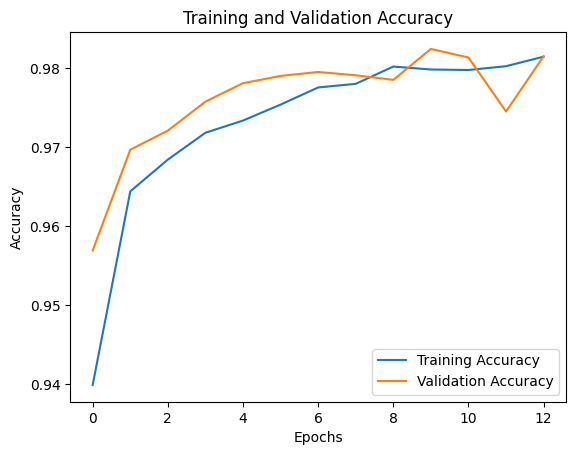

In [ ]:
import matplotlib.pyplot as plt



plt.plot(training_model.history['accuracy'], label='Training Accuracy')
plt.plot(training_model.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()


plt.show()

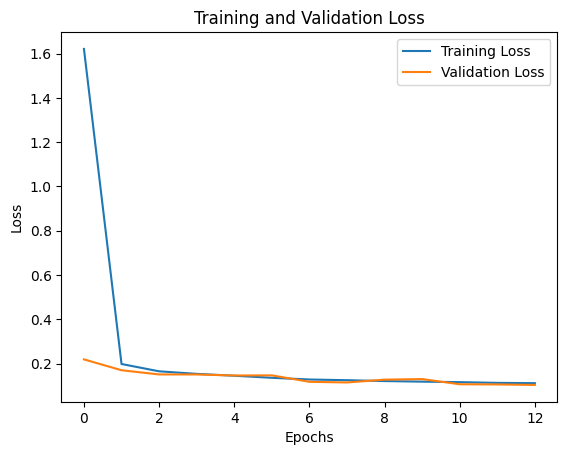

In [ ]:
import matplotlib.pyplot as plt


plt.plot(training_model.history['loss'], label='Training Loss')
plt.plot(training_model.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()


plt.show()

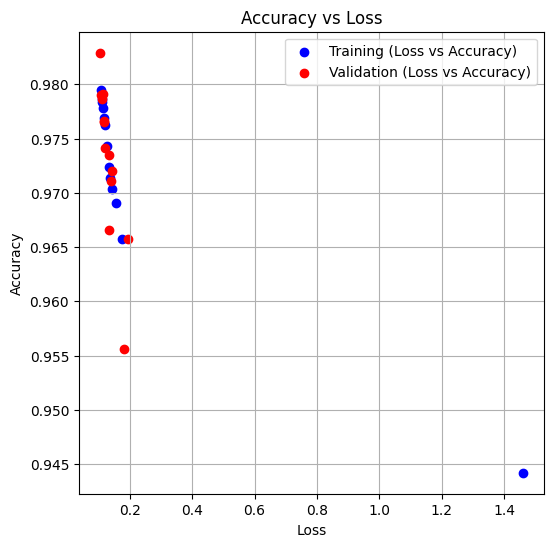

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_vs_accuracy(loss, accuracy, val_loss, val_accuracy):
    """
    損失と精度の関係をプロットする関数

    Parameters:
        loss (list): トレーニングデータの損失リスト
        accuracy (list): トレーニングデータの精度リスト
        val_loss (list): 検証データの損失リスト
        val_accuracy (list): 検証データの精度リスト
    """
    plt.figure(figsize=(6, 6))
    plt.scatter(loss, accuracy, color='blue', label='Training (Loss vs Accuracy)')
    plt.scatter(val_loss, val_accuracy, color='red', label='Validation (Loss vs Accuracy)')
    plt.title('Accuracy vs Loss')
    plt.xlabel('Loss')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()


plot_loss_vs_accuracy(loss, accuracy, val_loss, val_accuracy)

In [ ]:
# import numpy as np
# data = list(MultiQC)

# # print(data)



# # 各 array の左側の要素（最初の値）を取り出す
# left_elements = [arr[1] for arr in data]

# # 結果を表示
# print("左側の要素のみ:", left_elements)

# # 0.5より大きい要素を数える
# count_greater_than_0_5 = len([x for x in left_elements if x > 0.5])

# # 結果を表示
# print("0.5より大きい要素の数:", count_greater_than_0_5)